In [4]:
!pip install pyntcloud

In [6]:
import os
import re
import numpy as np
from pyntcloud import PyntCloud
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd

classes = {
    'bathtub': 0,
    'bed': 1,
    'chair': 2,
    'desk': 3,
    'dresser': 4,
    'monitor': 5,
    'night_stand': 6,
    'sofa': 7,
    'table': 8,
    'toilet': 9
}
root_dir = 'C:/Gaussian-Splatting/gaussian-splatting/output/modelNet10/'
class_paths = [(os.path.join(root_dir, name), name) for name in os.listdir(root_dir)]
model_paths = [(os.path.join(cls_path, name), label) for cls_path, label in class_paths for name in
                            os.listdir(cls_path)]

ModuleNotFoundError: No module named 'pyntcloud'

In [12]:
def _get_latest_point_cloud_path(model_path):
    """Finds the path of the latest point cloud by iteration number."""
    point_cloud_dir = os.path.join(model_path, 'point_cloud')
    iteration_dirs = [name for name in os.listdir(point_cloud_dir) if
                      os.path.isdir(os.path.join(point_cloud_dir, name))]

    # Extract the numeric part of the directory names using regex
    def extract_iteration_number(name):
        match = re.search(r'\d+', name)
        return int(match.group()) if match else -1

    # Find the directory with the highest numeric value
    latest_iteration_name = max(iteration_dirs, key=extract_iteration_number)

    # Return the path to the point cloud file inside the chosen iteration folder
    latest_iteration_dir = os.path.join(point_cloud_dir, latest_iteration_name)
    point_cloud_path = os.path.join(latest_iteration_dir, 'point_cloud.ply')

    return point_cloud_path

def retrieve_all_features():
    features_list = []
    for idx, (model_path, label) in enumerate(model_paths):
        point_cloud_path = _get_latest_point_cloud_path(model_path)
        point_cloud = PyntCloud.from_file(point_cloud_path)
        points = point_cloud.points[['x', 'y', 'z']].values.astype(np.float32)
        normals = point_cloud.points[['nx', 'ny', 'nz']].values.astype(np.float32)
        opacity = point_cloud.points['opacity'].values.astype(np.float32)
        sh_keys = [f'f_rest_{i}' for i in range(44)]
        spherical_harmonics = point_cloud.points[sh_keys].values.astype(np.float32)
        scale = point_cloud.points[['scale_0', 'scale_1', 'scale_2']].values.astype(np.float32)
        rotation = point_cloud.points[['rot_0', 'rot_1', 'rot_2', 'rot_3']].values.astype(np.float32)
        points_extended = np.concatenate((points, normals, scale, rotation, spherical_harmonics, opacity[:, None]), axis=1)
        features_list.append((points_extended, label, opacity))
    return features_list

gaussian_features = retrieve_all_features()
print(f'There are {len(gaussian_features)} models loaded')

There are 297 models loaded


In [14]:
# count total number of gaussians per model
# average number of gaussians per class
def compute_gaussians_stats(features_list):
    total_gaussians = []
    class_gaussians = {cls: [] for cls in classes.keys()}

    for features, cls, opacity in features_list:
        gaussians_count = len(opacity)
        total_gaussians.append(gaussians_count)
        class_gaussians[cls].append(gaussians_count)

    average_gaussians = {cls: np.mean(counts) for cls, counts in class_gaussians.items()}
    df_classes = pd.DataFrame(list(average_gaussians.items()), columns=['Class', 'Average Gaussians'])
    return total_gaussians, df_classes

total_gaussians, df_classes = compute_gaussians_stats(gaussian_features)
print(total_gaussians)
df_classes

[97818, 87290, 69274, 132871, 52644, 44270, 91623, 102910, 43303, 42319, 43314, 87887, 52056, 63601, 50499, 72080, 86159, 59836, 85731, 91366, 57194, 65088, 107875, 97144, 101626, 90288, 67901, 86052, 58928, 49306, 128779, 122689, 82736, 116939, 108162, 109220, 89285, 112424, 249617, 253488, 111938, 109898, 115110, 114332, 84339, 93511, 113062, 114754, 96948, 166644, 118819, 116009, 91547, 109452, 79617, 125975, 78263, 144118, 133043, 151724, 106083, 113433, 106000, 65380, 142799, 104629, 158093, 98667, 72347, 73846, 108726, 81811, 175390, 138143, 87750, 99354, 92183, 92454, 95655, 95889, 88102, 115373, 182838, 103275, 124679, 105788, 85923, 87389, 86123, 109735, 140554, 122500, 60375, 71667, 124088, 68445, 85337, 120134, 78007, 136423, 91914, 102725, 123173, 120441, 148108, 136347, 98371, 70513, 54511, 58892, 131227, 61698, 91399, 99631, 130822, 98399, 93291, 62204, 85253, 115830, 85795, 83430, 99959, 111494, 90658, 64298, 111297, 128649, 137369, 126307, 126812, 71888, 134861, 145573,

,Class,Average Gaussians
0,bathtub,74608.433333
1,bed,121414.733333
2,chair,106201.171429
3,desk,97814.366667
4,dresser,121563.384615
5,monitor,89573.066667
6,night_stand,148922.700000
7,sofa,83931.076923
8,table,107235.233333
9,toilet,108997.100000


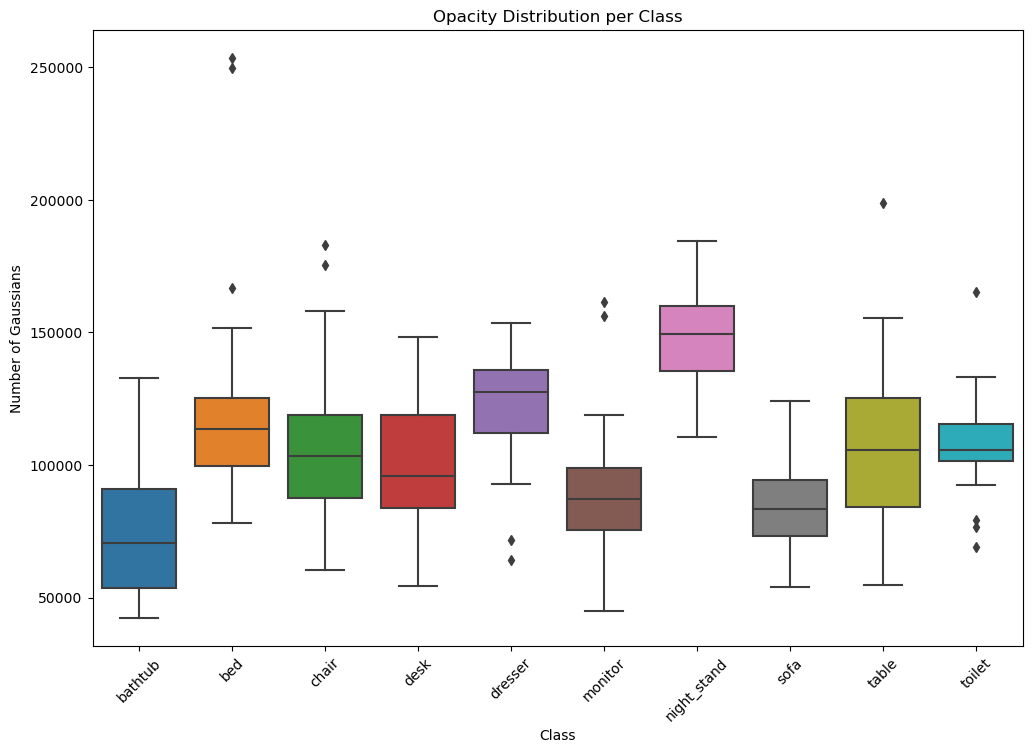

In [25]:
# box plot of point opacities per model, then per class
def plot_gaussian_distribution(features_list):
    no_data = []
    for features, cls, opacity in features_list:
        gaussians_count = len(opacity)
        no_data.append({'Number of Gaussians': gaussians_count, 'Class': cls})

    df = pd.DataFrame(no_data)
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Class', y='Number of Gaussians', data=df)
    plt.xticks(rotation=45)
    plt.title('Opacity Distribution per Class')
    plt.show()

plot_gaussian_distribution(gaussian_features)

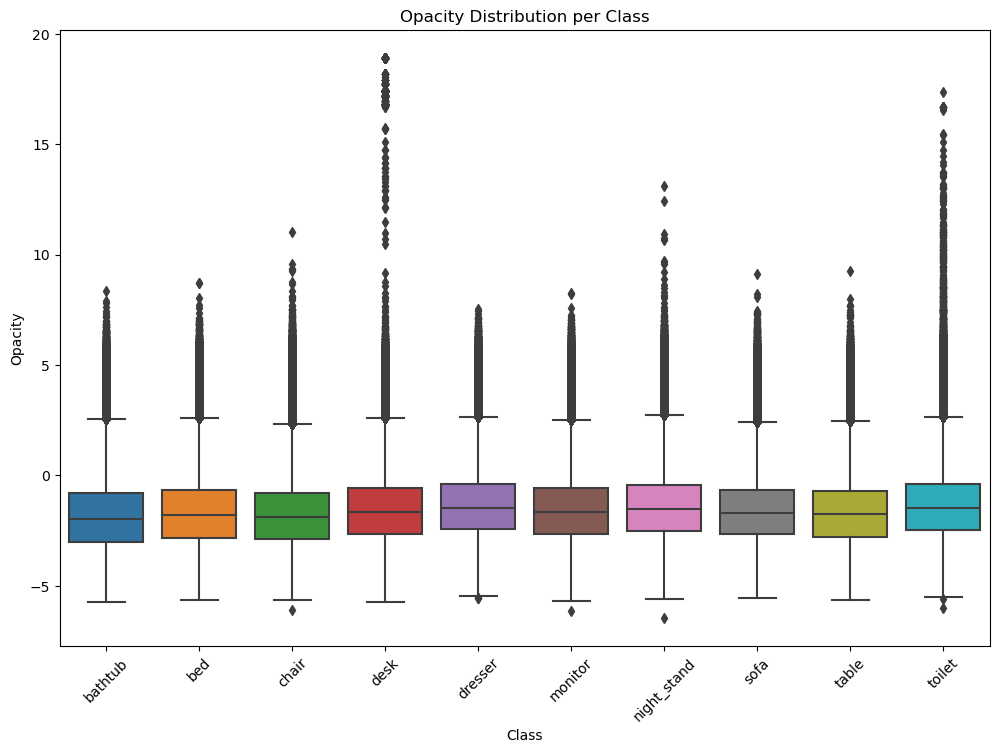

In [17]:
# box plot of point opacities per model, then per class
def plot_opacity_distribution(features_list):
    opacity_data = []
    for features, cls, opacity in features_list:
        for op in opacity:
            opacity_data.append({'Opacity': op, 'Class': cls})

    df = pd.DataFrame(opacity_data)
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Class', y='Opacity', data=df)
    plt.xticks(rotation=45)
    plt.title('Opacity Distribution per Class')
    plt.show()

plot_opacity_distribution(gaussian_features)

In [32]:
# number of points above specific opacity threshold levels (0.5, 0.6, ...) per model, then per class,
def opacity_threshold_analysis_for_plot(features_list, thresholds=None):
    if thresholds is None:
        thresholds = [0.5, 0.75, 1, 1.5, 2.0]
    
    plot_data = []
    for (features, cls, opacity), (_, label) in zip(features_list, model_paths):
        for threshold in thresholds:
            count_above_threshold = np.sum(opacity > threshold)
            plot_data.append({
                "Model": label,
                "Class": cls,
                "Threshold": f"Opacity > {threshold}",
                "Points Above Threshold": count_above_threshold
            })
    return pd.DataFrame(plot_data)

df_thresholds = opacity_threshold_analysis_for_plot(gaussian_features)
print(df_thresholds)

        Model    Class       Threshold  Points Above Threshold
0     bathtub  bathtub   Opacity > 0.5                    9415
1     bathtub  bathtub  Opacity > 0.75                    7563
2     bathtub  bathtub     Opacity > 1                    6064
3     bathtub  bathtub   Opacity > 1.5                    3838
4     bathtub  bathtub   Opacity > 2.0                    2453
...       ...      ...             ...                     ...
1480   toilet   toilet   Opacity > 0.5                   14402
1481   toilet   toilet  Opacity > 0.75                   11691
1482   toilet   toilet     Opacity > 1                    9460
1483   toilet   toilet   Opacity > 1.5                    6166
1484   toilet   toilet   Opacity > 2.0                    4100

[1485 rows x 4 columns]


Minimum number of points above threshold Opacity > 0.5: 1683
Minimum number of points above threshold Opacity > 0.75: 1242
Minimum number of points above threshold Opacity > 1: 929
Minimum number of points above threshold Opacity > 1.5: 476
Minimum number of points above threshold Opacity > 2.0: 219


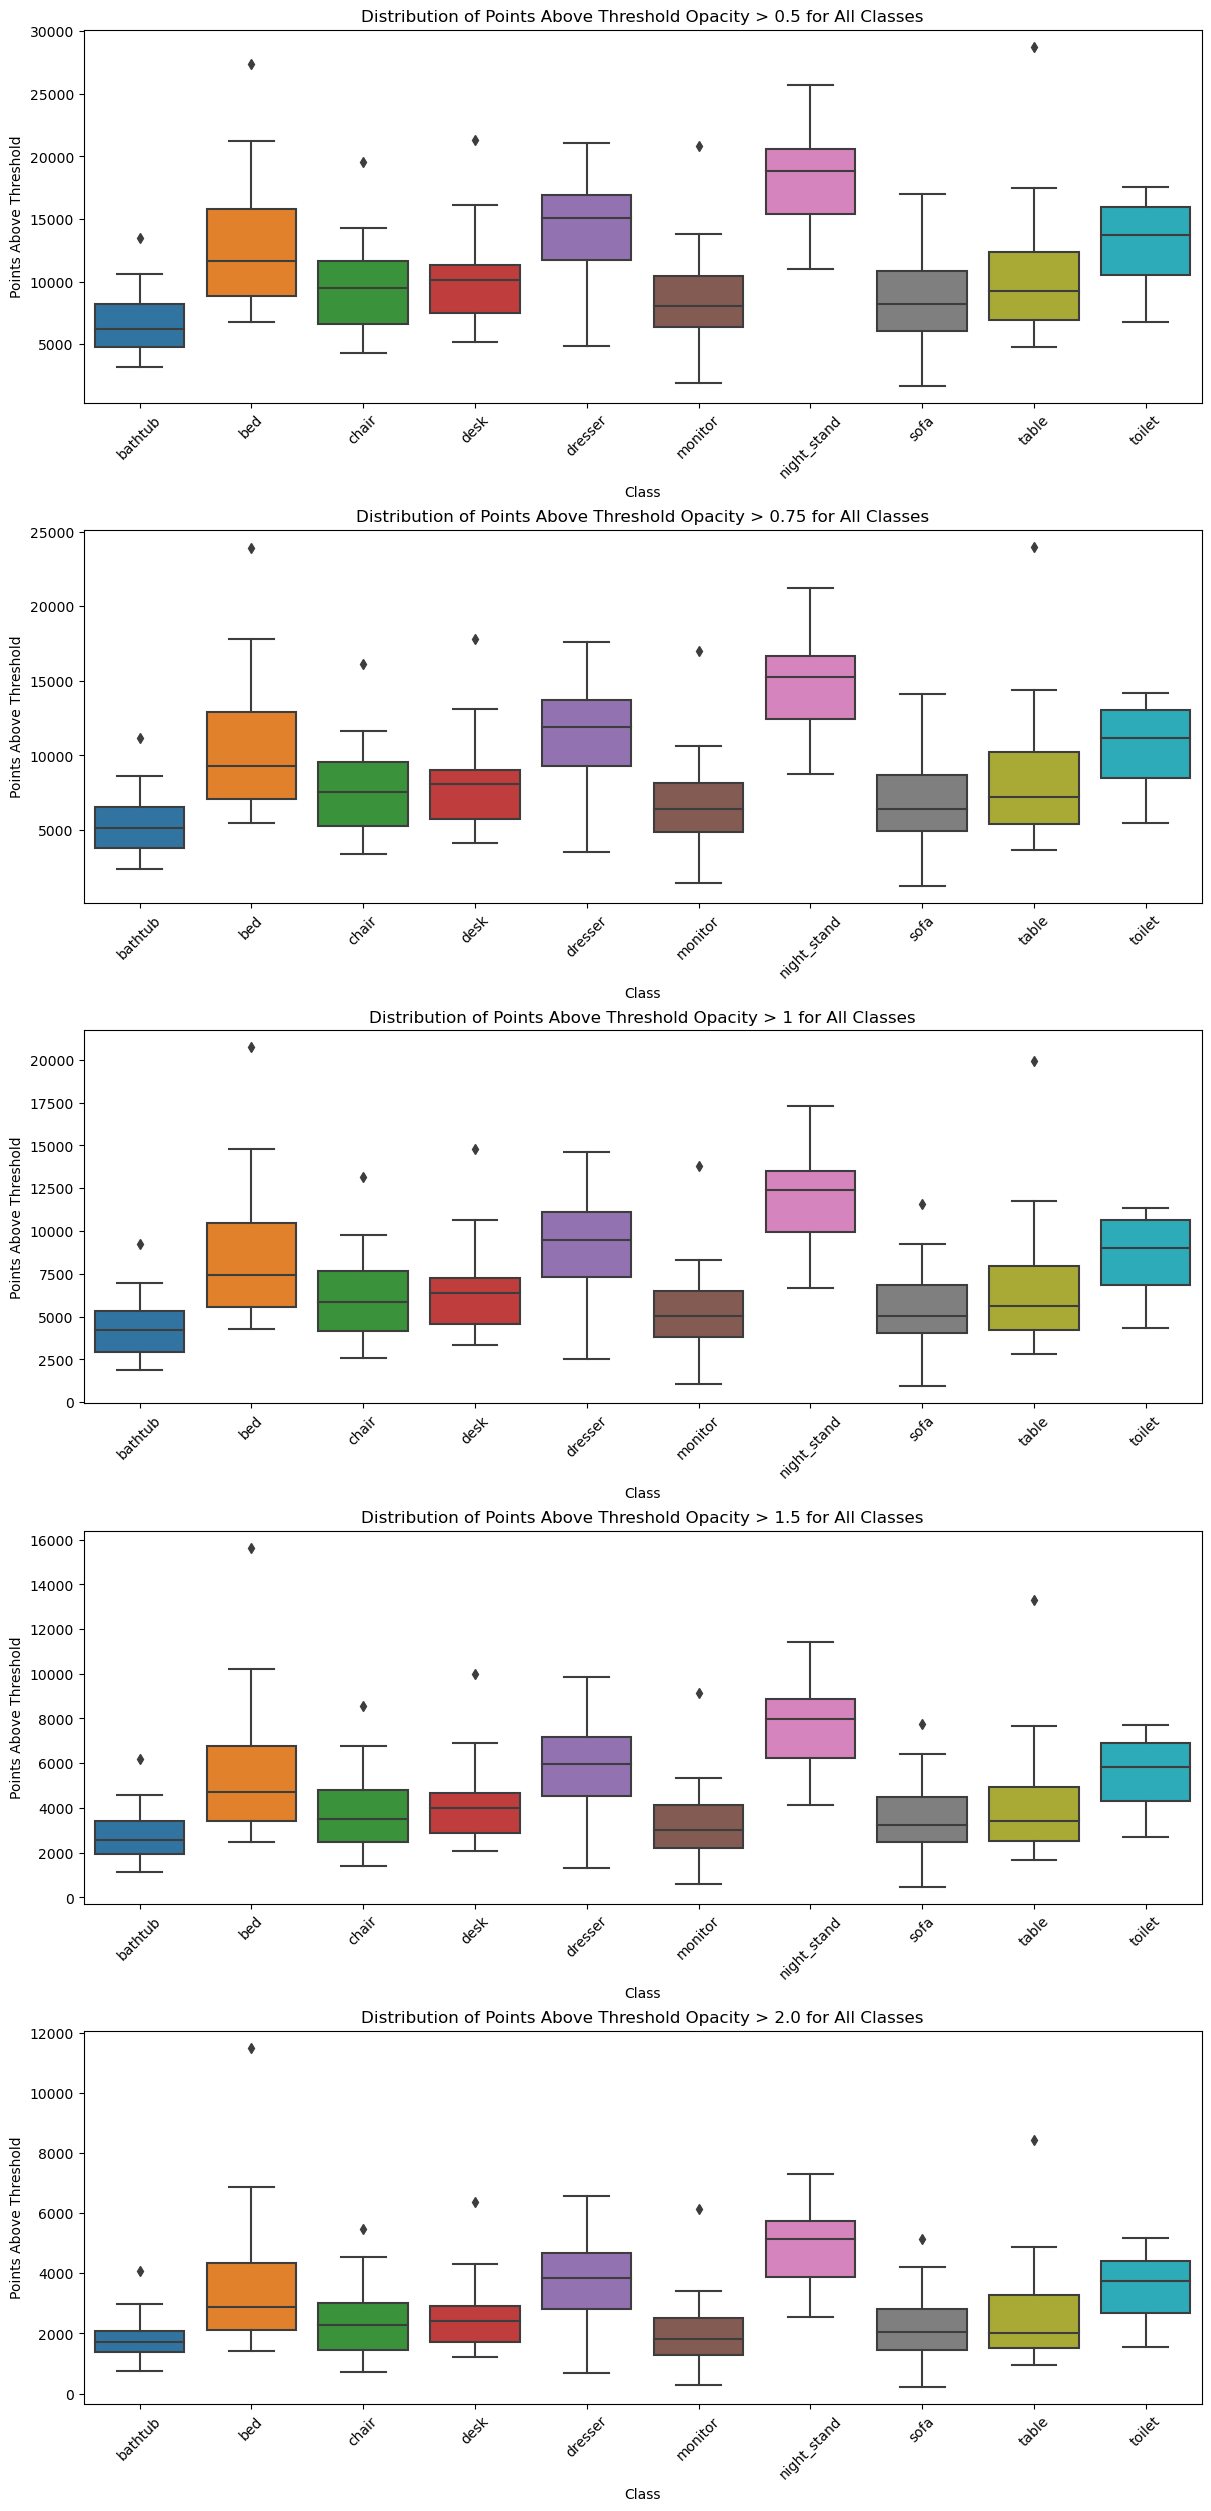

In [36]:
def plot_thresholds_by_opacity(df_thresholds):
    thresholds = df_thresholds['Threshold'].unique()
    num_thresholds = len(thresholds)
    fig, axes = plt.subplots(nrows=num_thresholds, figsize=(12, num_thresholds * 5), constrained_layout=True)

    for i, threshold in enumerate(thresholds):
        ax = axes[i] if num_thresholds > 1 else axes
        current_data = df_thresholds[df_thresholds['Threshold'] == threshold]
        sns.boxplot(data=current_data, x='Class', y='Points Above Threshold', ax=ax)
        ax.set_title(f'Distribution of Points Above Threshold {threshold} for All Classes')
        ax.set_xlabel('Class')
        ax.set_ylabel('Points Above Threshold')
        ax.tick_params(axis='x', rotation=45)

        min_points = current_data['Points Above Threshold'].min()
        print(f"Minimum number of points above threshold {threshold}: {min_points}")

    plt.show()

plot_thresholds_by_opacity(df_thresholds)